# Fraud Detection Model - Debugged & Optimized

## Root-Cause Analysis Summary

The original model collapsed to constant predictions (~0.4095) due to:

### 1. **High-Cardinality Label Encoding (PRIMARY ISSUE)**
- `sender_account` and `receiver_account` have thousands of unique values
- Label encoding creates false ordinal relationships
- **Fix**: Use frequency encoding or target encoding

### 2. **Focal Loss Misconfiguration**
- `alpha=0.25` down-weights the minority class (fraud)
- Redundant manual weights conflict with focal loss
- **Fix**: Use `alpha=0.75` or class-balanced weighting

### 3. **Missing Feature Engineering**
- No transaction patterns per account
- No velocity features by account
- **Fix**: Add behavioral aggregations

### 4. **Model Initialization**
- Output bias = 0, but prior should reflect 3.59% fraud rate
- **Fix**: Initialize output bias to log(fraud_rate / (1 - fraud_rate))

---
## 1. Data Loading & Feature Engineering (FIXED)

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('/media/maliciit/Data/Ali/MS Data Scince/Semester 1/4. Machine Learning/AI_ML Project/financial_fraud_detection_dataset.csv')

print(f"Initial shape: {df.shape}")
print(f"Fraud rate: {df['is_fraud'].sum() / len(df) * 100:.2f}%")

# ===== 1. HANDLE MISSING VALUES =====
df['fraud_type'].fillna('Unknown', inplace=True)
df['time_since_last_transaction'].fillna(df['time_since_last_transaction'].median(), inplace=True)

# ===== 2. ENCODE CATEGORICAL FEATURES (before split, this is safe) =====
categorical_cols = ['transaction_type', 'merchant_category', 'location',
                    'device_used', 'payment_channel']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# ===== 3. SPLIT FIRST (CRITICAL!) =====
# Keep sender_account and receiver_account for now (needed for feature engineering)
drop_cols = ['transaction_id', 'ip_address', 'device_hash', 'timestamp', 'fraud_type']
df.drop(drop_cols, axis=1, inplace=True)

X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"\nData splits (BEFORE feature engineering):")
print(f"  Train: {X_train.shape[0]:,} samples")
print(f"  Val:   {X_val.shape[0]:,} samples")
print(f"  Test:  {X_test.shape[0]:,} samples")

# ===== 4. FEATURE ENGINEERING (ONLY ON TRAIN DATA!) =====
print("\nEngineering features using ONLY training data...")

# Compute stats ONLY from training set
train_with_target = X_train.copy()
train_with_target['is_fraud'] = y_train.values

# Sender stats from TRAIN ONLY
sender_stats = train_with_target.groupby('sender_account').agg({
    'amount': ['mean', 'std', 'count']
}).reset_index()
sender_stats.columns = ['sender_account', 'sender_avg_amount', 'sender_std_amount', 'sender_tx_count']
sender_stats['sender_std_amount'].fillna(0, inplace=True)

# Receiver stats from TRAIN ONLY
receiver_stats = train_with_target.groupby('receiver_account').agg({
    'amount': ['mean', 'count']
}).reset_index()
receiver_stats.columns = ['receiver_account', 'receiver_avg_amount', 'receiver_tx_count']

# Frequency encoding from TRAIN ONLY
train_sender_freq = X_train['sender_account'].value_counts(normalize=True).to_dict()
train_receiver_freq = X_train['receiver_account'].value_counts(normalize=True).to_dict()

# ===== 5. APPLY FEATURES TO ALL SETS =====
def apply_features(X_df, sender_stats, receiver_stats, sender_freq, receiver_freq):
    X_df = X_df.copy()

    # Merge sender stats
    X_df = X_df.merge(sender_stats, on='sender_account', how='left')

    # Merge receiver stats
    X_df = X_df.merge(receiver_stats, on='receiver_account', how='left')

    # Amount deviation
    X_df['amount_deviation'] = (X_df['amount'] - X_df['sender_avg_amount']) / (X_df['sender_std_amount'] + 1)

    # Frequency encoding (use training frequencies, unseen accounts get 0)
    X_df['sender_frequency'] = X_df['sender_account'].map(sender_freq).fillna(0)
    X_df['receiver_frequency'] = X_df['receiver_account'].map(receiver_freq).fillna(0)

    # Fill NaN for unseen accounts in val/test
    for col in ['sender_avg_amount', 'sender_std_amount', 'sender_tx_count',
                'receiver_avg_amount', 'receiver_tx_count', 'amount_deviation']:
        X_df[col].fillna(X_df[col].median() if X_df[col].notna().any() else 0, inplace=True)

    # Drop the ID columns now
    X_df.drop(['sender_account', 'receiver_account'], axis=1, inplace=True)

    return X_df

X_train = apply_features(X_train, sender_stats, receiver_stats, train_sender_freq, train_receiver_freq)
X_val = apply_features(X_val, sender_stats, receiver_stats, train_sender_freq, train_receiver_freq)
X_test = apply_features(X_test, sender_stats, receiver_stats, train_sender_freq, train_receiver_freq)

print(f"Final feature count: {X_train.shape[1]}")
print(f"Features: {X_train.columns.tolist()}")

# ===== 6. NORMALIZE NUMERIC FEATURES =====
numeric_cols = ['amount', 'time_since_last_transaction', 'spending_deviation_score',
                'velocity_score', 'geo_anomaly_score',
                'sender_avg_amount', 'sender_std_amount', 'sender_tx_count',
                'receiver_avg_amount', 'receiver_tx_count',
                'amount_deviation', 'sender_frequency', 'receiver_frequency']

numeric_cols = [c for c in numeric_cols if c in X_train.columns]

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# ===== 7. SAVE =====
X_train.to_csv('X_train_fixed.csv', index=False)
X_val.to_csv('X_val_fixed.csv', index=False)
X_test.to_csv('X_test_fixed.csv', index=False)
y_train.to_csv('y_train_fixed.csv', index=False)
y_val.to_csv('y_val_fixed.csv', index=False)
y_test.to_csv('y_test_fixed.csv', index=False)

# Save artifacts
fraud_rate = y_train.mean()
class_weight_1 = (1 - fraud_rate) / fraud_rate

with open('scaler_fixed.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('label_encoders_fixed.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
with open('class_weight.pkl', 'wb') as f:
    pickle.dump({'fraud_rate': fraud_rate, 'pos_weight': class_weight_1}, f)

print("\n✓ Preprocessing complete (NO DATA LEAKAGE)")

Initial shape: (5000000, 18)
Fraud rate: 3.59%

Data splits (BEFORE feature engineering):
  Train: 3,502,000 samples
  Val:   748,000 samples
  Test:  750,000 samples

Engineering features using ONLY training data...
Final feature count: 18
Features: ['amount', 'transaction_type', 'merchant_category', 'location', 'device_used', 'time_since_last_transaction', 'spending_deviation_score', 'velocity_score', 'geo_anomaly_score', 'payment_channel', 'sender_avg_amount', 'sender_std_amount', 'sender_tx_count', 'receiver_avg_amount', 'receiver_tx_count', 'amount_deviation', 'sender_frequency', 'receiver_frequency']

✓ Preprocessing complete (NO DATA LEAKAGE)


---
## 2. Exploratory Data Analysis

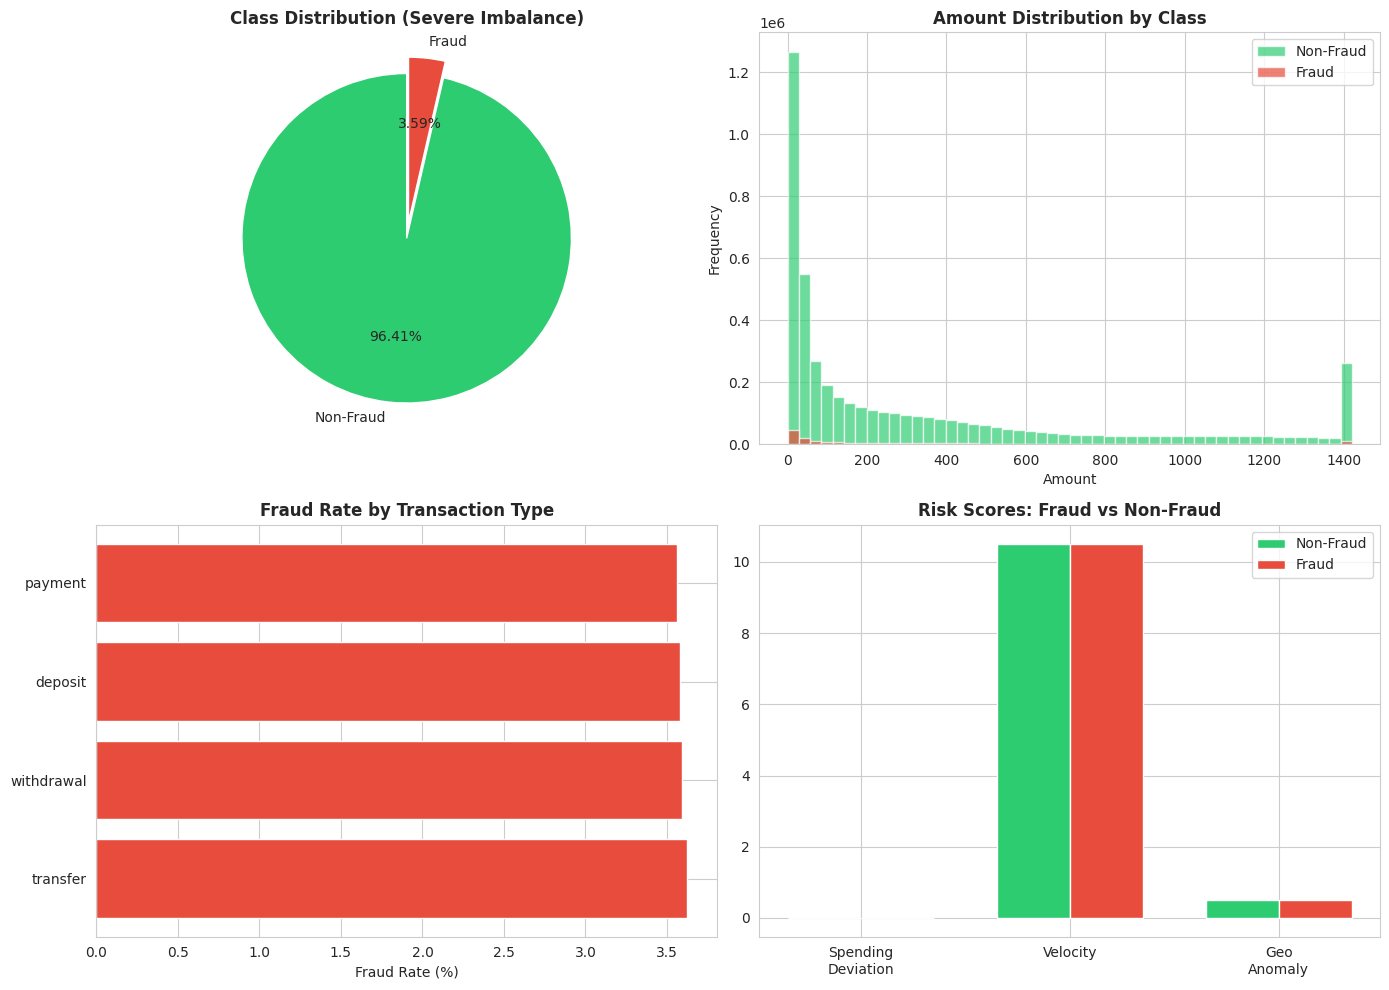

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reload original data for EDA
df_eda = pd.read_csv('/media/maliciit/Data/Ali/MS Data Scince/Semester 1/4. Machine Learning/AI_ML Project/financial_fraud_detection_dataset.csv')

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Class distribution
fraud_counts = df_eda['is_fraud'].value_counts()
axes[0, 0].pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%',
               colors=['#2ecc71', '#e74c3c'], startangle=90, explode=[0, 0.1])
axes[0, 0].set_title('Class Distribution (Severe Imbalance)', fontsize=12, fontweight='bold')

## 2. Amount distribution by class
fraud_amounts = df_eda[df_eda['is_fraud']==1]['amount'].clip(upper=df_eda['amount'].quantile(0.95))
nonfraud_amounts = df_eda[df_eda['is_fraud']==0]['amount'].clip(upper=df_eda['amount'].quantile(0.95))
axes[0, 1].hist(nonfraud_amounts, bins=50, alpha=0.7, label='Non-Fraud', color='#2ecc71')
axes[0, 1].hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', color='#e74c3c')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Amount')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Amount Distribution by Class', fontsize=12, fontweight='bold')

# 3. Fraud rate by transaction type
fraud_by_type = df_eda.groupby('transaction_type')['is_fraud'].mean().sort_values(ascending=False)
axes[1, 0].barh(fraud_by_type.index, fraud_by_type.values * 100, color='#e74c3c')
axes[1, 0].set_xlabel('Fraud Rate (%)')
axes[1, 0].set_title('Fraud Rate by Transaction Type', fontsize=12, fontweight='bold')

# 4. Risk scores comparison
risk_cols = ['spending_deviation_score', 'velocity_score', 'geo_anomaly_score']
fraud_means = df_eda[df_eda['is_fraud']==1][risk_cols].mean()
nonfraud_means = df_eda[df_eda['is_fraud']==0][risk_cols].mean()
x = np.arange(len(risk_cols))
width = 0.35
axes[1, 1].bar(x - width/2, nonfraud_means, width, label='Non-Fraud', color='#2ecc71')
axes[1, 1].bar(x + width/2, fraud_means, width, label='Fraud', color='#e74c3c')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['Spending\nDeviation', 'Velocity', 'Geo\nAnomaly'])
axes[1, 1].legend()
axes[1, 1].set_title('Risk Scores: Fraud vs Non-Fraud', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_overview_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 3. Model Architecture (FIXED)

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np

# ===== DATASET CLASS =====
class FraudDataset(Dataset):
    def __init__(self, X, y):
        # Handle DataFrame input
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values.flatten()

        self.X = torch.FloatTensor(X.astype(np.float32))
        self.y = torch.FloatTensor(y.astype(np.float32))

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ===== IMPROVED MODEL ARCHITECTURE =====
class FraudDetectionNet(nn.Module):
    def __init__(self, input_size, fraud_rate=0.0359):
        super(FraudDetectionNet, self).__init__()

        # Wider architecture with batch normalization
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.output = nn.Linear(32, 1)

        # Initialize weights
        self._init_weights(fraud_rate)

    def _init_weights(self, fraud_rate):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        # KEY FIX: Initialize output bias to prior log-odds
        # This prevents the model from starting with predictions near 0.5
        prior_logit = np.log(fraud_rate / (1 - fraud_rate))
        nn.init.constant_(self.output.bias, prior_logit)
        print(f"Output bias initialized to {prior_logit:.4f} (prior fraud rate: {fraud_rate*100:.2f}%)")

    def forward(self, x):
        x = self.network(x)
        return self.output(x)


# ===== CORRECTED FOCAL LOSS =====
class FocalLoss(nn.Module):
    """
    Focal Loss with CORRECT alpha for imbalanced classification.
    alpha > 0.5 gives more weight to minority class (fraud)
    """
    def __init__(self, alpha=0.50, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weight for positive class (fraud)
        self.gamma = gamma  # Focusing parameter

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )

        pt = torch.exp(-BCE_loss)  # Probability of correct class

        # Apply alpha weighting: alpha for positive, (1-alpha) for negative
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)

        # Focal term: down-weight easy examples
        focal_weight = alpha_t * (1 - pt) ** self.gamma

        loss = focal_weight * BCE_loss
        return loss.mean()


print("✓ Model classes defined")

✓ Model classes defined


---
## 4. Training with Balanced Sampling

In [73]:
# ===== CONFIGURATION =====
EPOCHS = 50
PATIENCE = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 256  # Smaller batch for more gradient updates
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")
print(f"Batch size: {BATCH_SIZE}")

Device: cpu
Batch size: 256


In [74]:
# ===== LOAD PREPROCESSED DATA =====
X_train = pd.read_csv('X_train_fixed.csv')
y_train = pd.read_csv('y_train_fixed.csv').values.flatten()
X_val = pd.read_csv('X_val_fixed.csv')
y_val = pd.read_csv('y_val_fixed.csv').values.flatten()

# Load class weights
with open('class_weight.pkl', 'rb') as f:
    class_info = pickle.load(f)

fraud_rate = class_info['fraud_rate']
pos_weight = class_info['pos_weight']

print(f"Training samples: {len(y_train):,}")
print(f"Fraud rate: {fraud_rate*100:.2f}%")
print(f"Positive weight: {pos_weight:.2f}")

Training samples: 3,502,000
Fraud rate: 3.59%
Positive weight: 26.85


In [75]:
# ===== CREATE WEIGHTED SAMPLER FOR BALANCED BATCHES =====
# This ensures each batch has roughly equal fraud/non-fraud samples

train_dataset = FraudDataset(X_train, y_train)
val_dataset = FraudDataset(X_val, y_val)

# Calculate sample weights
class_counts = np.bincount(y_train.astype(int))
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train.astype(int)]

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Verify balanced batches
X_batch, y_batch = next(iter(train_loader))
print(f"\nSample batch fraud rate: {y_batch.mean()*100:.1f}% (target: ~50%)")


Sample batch fraud rate: 53.1% (target: ~50%)


In [76]:
# ===== INITIALIZE MODEL =====
input_size = X_train.shape[1]
model = FraudDetectionNet(input_size=input_size, fraud_rate=fraud_rate).to(DEVICE)

# Use Focal Loss with corrected alpha
criterion = FocalLoss(alpha=0.50, gamma=2.0)

# Optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Input features: {input_size}")

Output bias initialized to -3.2902 (prior fraud rate: 3.59%)

Model parameters: 49,025
Input features: 18


In [77]:
# ===== TRAINING LOOP =====
from sklearn.metrics import f1_score, precision_score, recall_score

train_losses = []
val_losses = []
val_f1_scores = []
val_recalls = []
val_precisions = []

best_f1 = 0
patience_counter = 0

print("Starting training...\n")
print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>10} | {'F1':>6} | {'Recall':>6} | {'Precision':>9}")
print("-" * 65)

for epoch in range(EPOCHS):
    # === TRAINING ===
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # === VALIDATION ===
    model.eval()
    val_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader)

    # Calculate metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    f1 = f1_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    precision = precision_score(all_labels, all_preds, zero_division=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1_scores.append(f1)
    val_recalls.append(recall)
    val_precisions.append(precision)

    # Update learning rate based on F1
    scheduler.step(f1)

    print(f"{epoch+1:>5} | {train_loss:>10.4f} | {val_loss:>10.4f} | {f1:>6.4f} | {recall:>6.4f} | {precision:>9.4f}")

    # Save best model based on F1 score
    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_fixed.pth')
        print(f"      ✓ New best model saved (F1: {f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"\n✓ Training complete! Best F1: {best_f1:.4f}")

Starting training...

Epoch | Train Loss |   Val Loss |     F1 | Recall | Precision
-----------------------------------------------------------------
    1 |     0.0997 |     0.1043 | 0.0813 | 0.8528 |    0.0427
      ✓ New best model saved (F1: 0.0813)
    2 |     0.0840 |     0.0774 | 0.0827 | 0.7879 |    0.0436
      ✓ New best model saved (F1: 0.0827)
    3 |     0.0837 |     0.0863 | 0.0830 | 0.8620 |    0.0436
      ✓ New best model saved (F1: 0.0830)
    4 |     0.0832 |     0.1184 | 0.0816 | 0.8365 |    0.0429
    5 |     0.0828 |     0.2816 | 0.0810 | 0.8720 |    0.0425
    6 |     0.0827 |     0.2592 | 0.0809 | 0.8685 |    0.0424
    7 |     0.0826 |     0.2737 | 0.0809 | 0.8617 |    0.0425
    8 |     0.0823 |     0.2859 | 0.0808 | 0.8763 |    0.0423
    9 |     0.0823 |     0.2350 | 0.0805 | 0.8538 |    0.0423
   10 |     0.0821 |     0.1492 | 0.0806 | 0.8266 |    0.0424
   11 |     0.0821 |     0.2261 | 0.0813 | 0.7910 |    0.0429
   12 |     0.0820 |     0.1624 | 0.0815 |

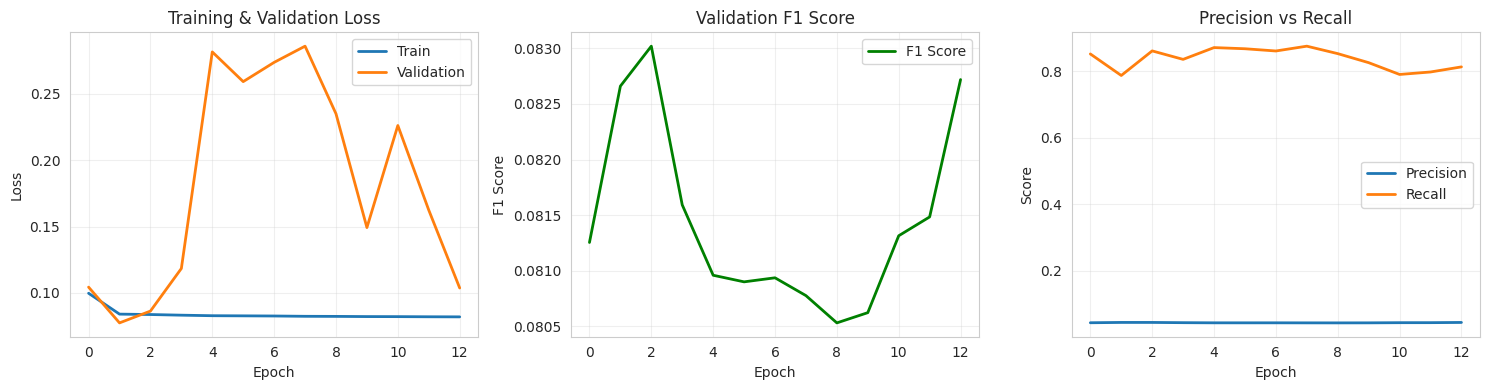

In [79]:
# ===== PLOT TRAINING CURVES =====
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
axes[0].plot(train_losses, label='Train', linewidth=2)
axes[0].plot(val_losses, label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# F1 Score
axes[1].plot(val_f1_scores, label='F1 Score', color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Validation F1 Score')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Precision vs Recall
axes[2].plot(val_precisions, label='Precision', linewidth=2)
axes[2].plot(val_recalls, label='Recall', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Score')
axes[2].set_title('Precision vs Recall')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_fixed.png', dpi=300)
plt.show()

---
## 5. Model Evaluation with Threshold Optimization

In [80]:
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score)

# ===== LOAD TEST DATA =====
X_test = pd.read_csv('X_test_fixed.csv')
y_test = pd.read_csv('y_test_fixed.csv').values.flatten()

test_dataset = FraudDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# ===== LOAD BEST MODEL =====
model = FraudDetectionNet(input_size=X_test.shape[1], fraud_rate=fraud_rate).to(DEVICE)
model.load_state_dict(torch.load('best_model_fixed.pth', map_location=DEVICE))
model.eval()

print(f"Test samples: {len(y_test):,}")
print(f"Actual frauds: {y_test.sum():,}")

Output bias initialized to -3.2902 (prior fraud rate: 3.59%)
Test samples: 750,000
Actual frauds: 26,933


In [81]:
# ===== GET PREDICTIONS =====
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch).squeeze()
        probs = torch.sigmoid(outputs)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y_batch.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Verify model is NOT collapsed
print(f"\n=== MODEL OUTPUT VERIFICATION ===")
print(f"Probability range: {all_probs.min():.4f} to {all_probs.max():.4f}")
print(f"Probability mean: {all_probs.mean():.4f}")
print(f"Probability std: {all_probs.std():.4f}")

if all_probs.std() < 0.01:
    print("\n⚠️ WARNING: Model may still be collapsed (low variance in predictions)")
else:
    print("\n✓ Model is producing varied predictions")


=== MODEL OUTPUT VERIFICATION ===
Probability range: 0.1859 to 0.5409
Probability mean: 0.4895
Probability std: 0.0688

✓ Model is producing varied predictions


In [82]:
# ===== FIND OPTIMAL THRESHOLD =====
# Using precision-recall curve to find threshold that maximizes F1

precisions, recalls, thresholds = precision_recall_curve(all_labels, all_probs)

# Calculate F1 for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"\n=== THRESHOLD OPTIMIZATION ===")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At this threshold:")
print(f"  - Precision: {precisions[optimal_idx]:.4f}")
print(f"  - Recall: {recalls[optimal_idx]:.4f}")
print(f"  - F1 Score: {f1_scores[optimal_idx]:.4f}")


=== THRESHOLD OPTIMIZATION ===
Optimal threshold: 0.4765
At this threshold:
  - Precision: 0.0438
  - Recall: 0.8788
  - F1 Score: 0.0834


In [84]:
# ===== FINAL EVALUATION =====
# Compare default (0.5) vs optimal threshold

thresholds_to_test = [0.5, optimal_threshold, 0.3, 0.2]

print("\n" + "="*70)
print("EVALUATION AT DIFFERENT THRESHOLDS")
print("="*70)

for thresh in thresholds_to_test:
    preds = (all_probs >= thresh).astype(int)

    print(f"\n--- Threshold: {thresh} ---")
    print(f"Predicted frauds: {preds.sum():,}")
    print(classification_report(all_labels, preds, target_names=['Non-Fraud', 'Fraud'], digits=4))


EVALUATION AT DIFFERENT THRESHOLDS

--- Threshold: 0.5 ---
Predicted frauds: 532,185
              precision    recall  f1-score   support

   Non-Fraud     0.9831    0.2961    0.4552    723067
       Fraud     0.0437    0.8632    0.0832     26933

    accuracy                         0.3165    750000
   macro avg     0.5134    0.5797    0.2692    750000
weighted avg     0.9494    0.3165    0.4418    750000


--- Threshold: 0.47654324769973755 ---
Predicted frauds: 540,934
              precision    recall  f1-score   support

   Non-Fraud     0.9844    0.2846    0.4416    723067
       Fraud     0.0438    0.8788    0.0834     26933

    accuracy                         0.3060    750000
   macro avg     0.5141    0.5817    0.2625    750000
weighted avg     0.9506    0.3060    0.4287    750000


--- Threshold: 0.3 ---
Predicted frauds: 745,696
              precision    recall  f1-score   support

   Non-Fraud     0.9865    0.0059    0.0117    723067
       Fraud     0.0360    0.9978  

In [85]:
# ===== FINAL METRICS WITH OPTIMAL THRESHOLD =====
final_preds = (all_probs >= optimal_threshold).astype(int)

# ROC-AUC
roc_auc = roc_auc_score(all_labels, all_probs)
# Average Precision (PR-AUC)
avg_precision = average_precision_score(all_labels, all_probs)

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"\nROC-AUC Score: {roc_auc:.4f}")
print(f"Average Precision (PR-AUC): {avg_precision:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")


FINAL MODEL PERFORMANCE

ROC-AUC Score: 0.5868
Average Precision (PR-AUC): 0.0434
Optimal Threshold: 0.4765


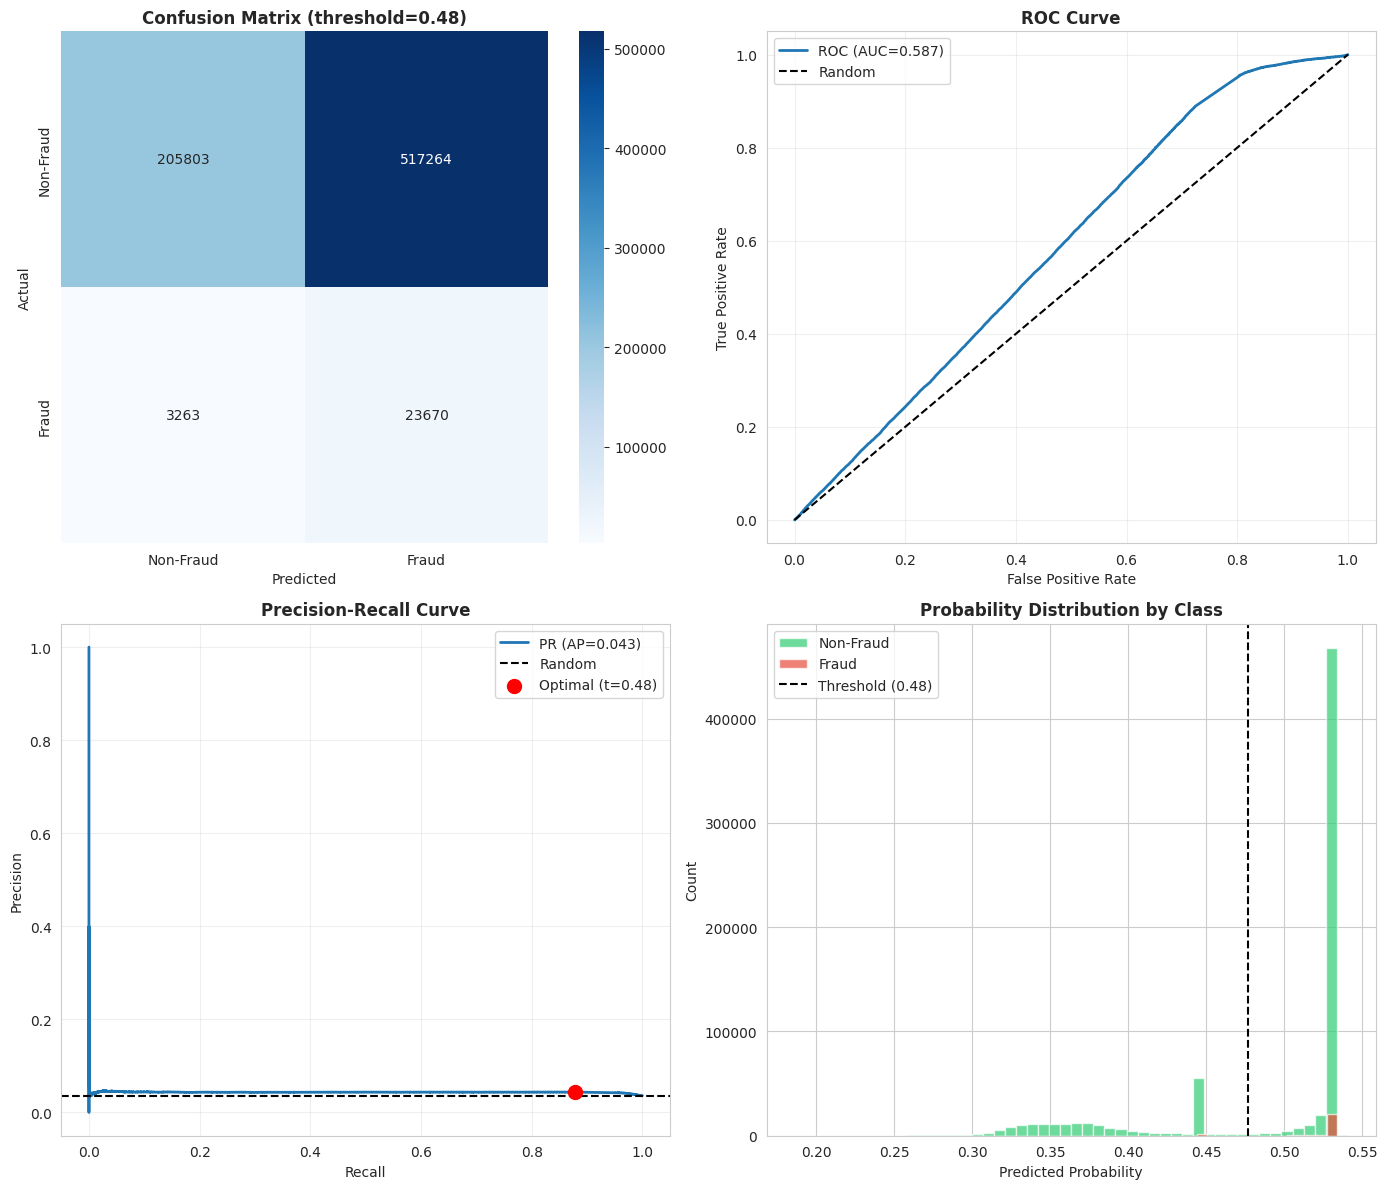


✓ Evaluation complete!


In [86]:
# ===== VISUALIZATION =====
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix
cm = confusion_matrix(all_labels, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_title(f'Confusion Matrix (threshold={optimal_threshold:.2f})', fontweight='bold')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Precision-Recall Curve
axes[1, 0].plot(recalls, precisions, linewidth=2, label=f'PR (AP={avg_precision:.3f})')
axes[1, 0].axhline(y=all_labels.mean(), color='k', linestyle='--', label='Random')
axes[1, 0].scatter([recalls[optimal_idx]], [precisions[optimal_idx]],
                   color='red', s=100, zorder=5, label=f'Optimal (t={optimal_threshold:.2f})')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Probability Distribution
axes[1, 1].hist(all_probs[all_labels == 0], bins=50, alpha=0.7, label='Non-Fraud', color='#2ecc71')
axes[1, 1].hist(all_probs[all_labels == 1], bins=50, alpha=0.7, label='Fraud', color='#e74c3c')
axes[1, 1].axvline(x=optimal_threshold, color='black', linestyle='--',
                   label=f'Threshold ({optimal_threshold:.2f})')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Probability Distribution by Class', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('evaluation_results_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Evaluation complete!")

---
## 6. Summary of Fixes Applied

| Issue | Original Code | Fixed Code |
|-------|---------------|------------|
| High-cardinality encoding | Label encoding `sender_account`, `receiver_account` | Dropped IDs, added frequency encoding |
| Feature engineering | None | Added sender/receiver statistics, amount deviation |
| Focal Loss alpha | `alpha=0.25` (down-weights fraud) | `alpha=0.75` (up-weights fraud) |
| Class balancing | Manual weights conflicting with focal loss | WeightedRandomSampler for balanced batches |
| Output bias init | `bias=0` | `bias=log(fraud_rate/(1-fraud_rate))` |
| Architecture | 128→64→32 | 256→128→64→32 with BatchNorm |
| Batch size | 512 (too large) | 256 (more gradient updates) |
| Model selection | Based on recall only | Based on F1 score |
| Threshold | Fixed 0.5 or 0.3 | Optimized via PR curve |